In [60]:
import numpy as np
import math
import pandas as pd

import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

from scipy.integrate import solve_ivp

from torchmetrics import Accuracy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

from tqdm import tqdm

from copy import deepcopy

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")

In [2]:
def system(t, X):
    x, y = X
    xp = -x-y-x*x
    yp = x-y-y*y
    return xp, yp

## Bisection method to generate near-boundary points
def bisection(a, b, delta=0.01): ## a has label +1 and b has label -1
    distance = np.linalg.norm(np.array([a[0]-b[0], a[1]-b[1]]))
    if distance < delta:
        return (a, b)
    else:
        c = ((a[0]+b[0])/2, (a[1]+b[1])/2)
        if simulation(c[0], c[1]):
            return bisection(c, b, delta)
        else:
            return bisection(a, c, delta)

def euclidean_distance(point1, point2):
    point1, point2 = np.array(point1), np.array(point2)
    return np.sqrt(np.sum((point1 - point2) ** 2))

spiral_sink = (0, 0)

# Check if the trajectory is attracted to the concerned spiral attractor
def is_attracted(x, y):
    return euclidean_distance((x, y), spiral_sink) < 1e-5

## Implement the simulation process and decide if the trajectory is attracted by the Lorenz attractor
def simulation(x0 ,y0):
    tmax, n = 1500, 100000
    soln = solve_ivp(system, (0, tmax), (x0, y0),dense_output=True)
    t = np.linspace(0, tmax, n)
    x, y= soln.sol(t)
    return is_attracted(x[n-1], y[n-1])


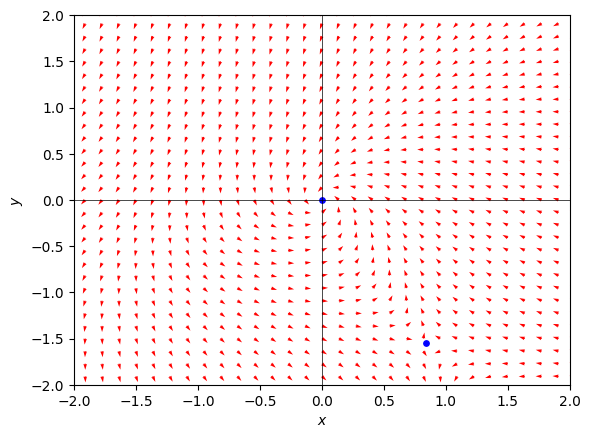

In [3]:
# Define the system of equations
Y, X = np.mgrid[-3:3:45j, -3:3:45j] 
U, V = system(0, (X, Y))

# Normalize arrows
N = np.sqrt(U**2 + V**2)
U = U / N
V = V / N

plt.quiver(X, Y, U, V, color='r')

# Highlight critical points
plt.scatter([0, 0.83928], [0, -1.54368], color='blue', s=15) 

# Add axes
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)

plt.xlim([-2, 2])  # x-axis limits include negative values
plt.ylim([-2, 2])  # y-axis limits include negative values
plt.xlabel('$x$')
plt.ylabel('$y$')

plt.show()

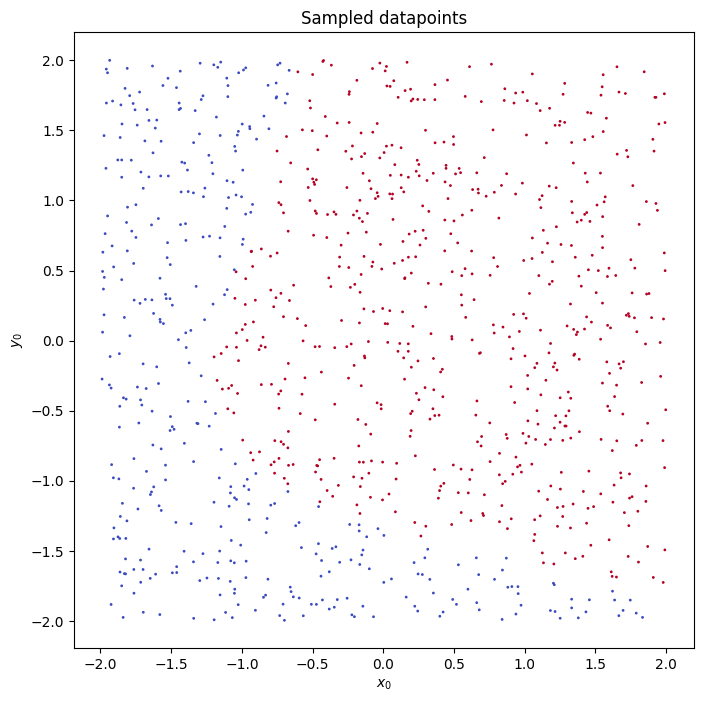

In [4]:
## Plot the training datapoints
df = pd.read_csv('dataset_arbi2d_new_training_1000.csv')
plt.figure(figsize=(8, 8))
plt.scatter(df['x0'], df['y0'], c=df['attracted'], cmap='coolwarm', s=1)
plt.xlabel('$x_0$')
plt.ylabel('$y_0$')
plt.title('Sampled datapoints')
plt.show()

In [5]:
dataset_train = pd.read_csv('dataset_arbi2d_new_training_1000.csv')
X_train = dataset_train[['x0', 'y0']].values
y_train = dataset_train['attracted'].values


In [6]:
dataset_test_uniform = pd.read_csv('dataset_arbi2d_new_testing_10000.csv').sample(1000)
X_test_uniform = dataset_test_uniform[['x0', 'y0']].values
y_test_uniform = dataset_test_uniform['attracted'].values 

In [7]:
dataset_test_near = pd.read_csv('dataset_arbi2d_new_testing_near_20000.csv').sample(1000)
X_test_near = dataset_test_near[['x0', 'y0']].values
y_test_near = dataset_test_near['attracted'].values

dataset_validation = pd.read_csv('dataset_arbi2d_new_testing_near_20000.csv').drop(dataset_test_near.index).sample(1000)
X_validation = dataset_validation[['x0', 'y0']].values
y_validation = dataset_validation['attracted'].values

In [8]:
model_1 = SVC(kernel='rbf', C=1)
model_1.fit(X_train, y_train)

SVC(C=1)

In [9]:
predictions = model_1.predict(X_test_uniform)
accuracy = accuracy_score(y_test_uniform, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.993


In [10]:
raw_values = model_1.decision_function(X_test_uniform)

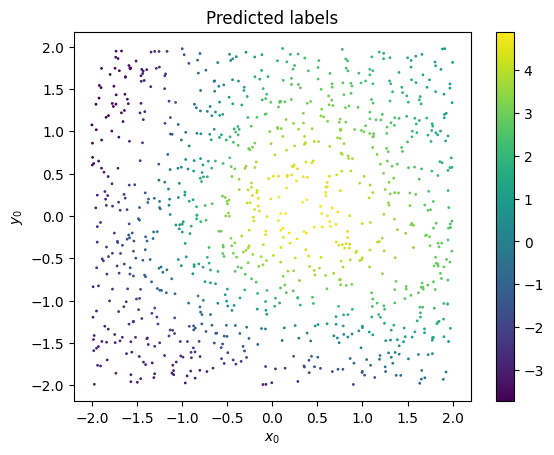

In [11]:
plt.scatter(dataset_test_uniform['x0'], dataset_test_uniform['y0'], c=raw_values, cmap='viridis', s=1)
plt.xlabel('$x_0$')
plt.ylabel('$y_0$')
plt.title('Predicted labels')
plt.colorbar()
plt.show()

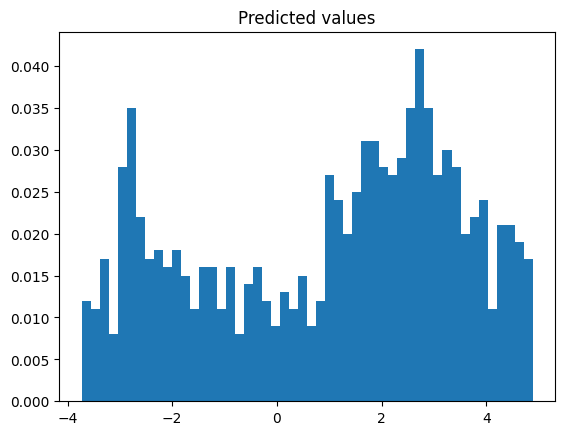

In [12]:
weights = np.ones_like(raw_values)/float(len(raw_values))
plt.hist(raw_values, weights=weights, bins=50)
plt.title('Predicted values')
plt.show()


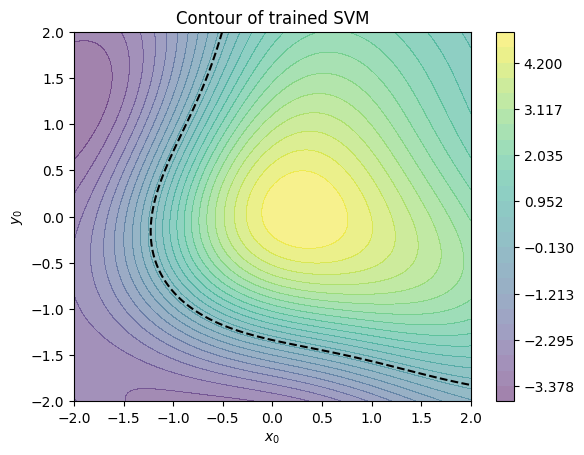

In [13]:
x_min, x_max = -2, 2
y_min, y_max = -2, 2
resolution = 2000
x_range = np.linspace(x_min, x_max, resolution)
y_range = np.linspace(y_min, y_max, resolution)
xx, yy = np.meshgrid(x_range, y_range)
grid = np.c_[xx.ravel(), yy.ravel()]
predictions = model_1.decision_function(grid).reshape(xx.shape)
plt.contourf(xx, yy, predictions, cmap='viridis', alpha=0.5, levels=np.linspace(predictions.min(), predictions.max(), 25))
plt.colorbar()
plt.contour(xx, yy, predictions, levels=[0], colors='k', linestyles='--')
plt.title("Contour of trained SVM")
plt.xlabel('$x_0$')
plt.ylabel('$y_0$')
plt.show()

In [14]:
predictions = model_1.predict(X_test_near)
accuracy = accuracy_score(y_test_near, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.534


In [15]:
raw_values = model_1.decision_function(X_test_near)

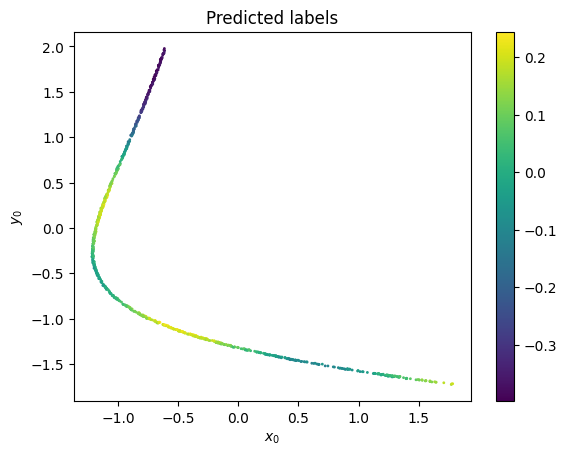

In [16]:
plt.scatter(dataset_test_near['x0'], dataset_test_near['y0'], c=raw_values, cmap='viridis', s=1)
plt.xlabel('$x_0$')
plt.ylabel('$y_0$')
plt.title('Predicted labels')
plt.colorbar()
plt.show()

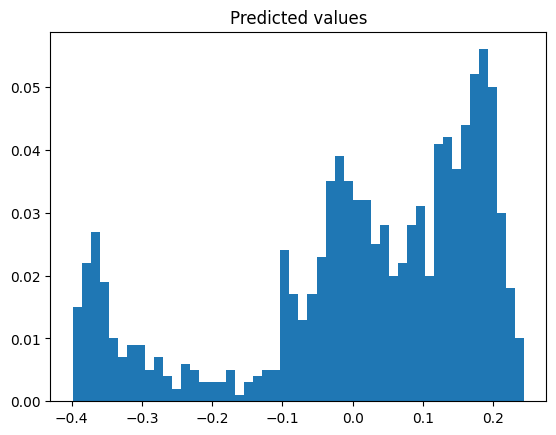

In [17]:
weights = np.ones_like(raw_values)/float(len(raw_values))
plt.hist(raw_values, weights=weights, bins=50)
plt.title('Predicted values')
plt.show()

In [18]:
df_data = dataset_train

df_data_1 = df_data[df_data['attracted'] == 1].sample(15)
df_data_n1 = df_data[df_data['attracted'] == -1].sample(15)

dataset_near = []
for i in tqdm(range(len(df_data_1)), desc="Processing df_1"):
    for j in range(len(df_data_n1)):
        a = (df_data_1.iloc[i]['x0'], df_data_1.iloc[i]['y0'])
        b = (df_data_n1.iloc[j]['x0'], df_data_n1.iloc[j]['y0'])
        a, b = bisection(a, b)
        dataset_near.append([a[0], a[1], 1])
        dataset_near.append([b[0], b[1], -1])

df_near = pd.DataFrame(dataset_near, columns=['x0', 'y0', 'attracted'])

dataset_train_augmented = pd.concat([dataset_train, df_near], ignore_index=True)

Processing df_1: 100%|██████████| 15/15 [00:57<00:00,  3.85s/it]


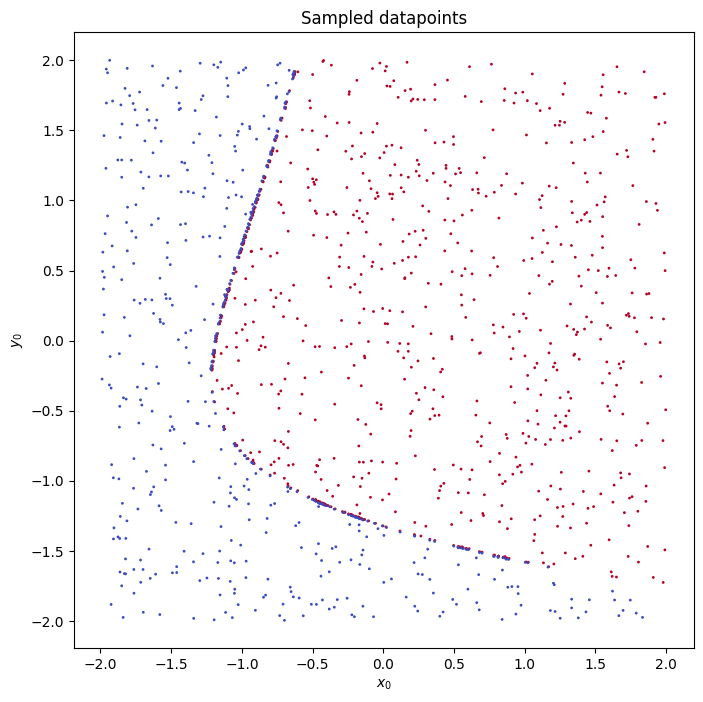

In [19]:
## Plot the sampled datapoints
df = dataset_train_augmented
plt.figure(figsize=(8, 8))
plt.scatter(df['x0'], df['y0'], c=df['attracted'], cmap='coolwarm', s=1)
plt.xlabel('$x_0$')
plt.ylabel('$y_0$')
plt.title('Sampled datapoints')
plt.show()

In [20]:
X_train_augmented = dataset_train_augmented[['x0', 'y0']].values
y_train_augmented = dataset_train_augmented['attracted'].values

In [21]:
model_2 = SVC(kernel='rbf', C=150)
model_2.fit(X_train_augmented, y_train_augmented)

SVC(C=150)

In [22]:
predictions = model_2.predict(X_test_uniform)
accuracy = accuracy_score(y_test_uniform, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.999


In [23]:
raw_values = model_2.decision_function(X_test_uniform)

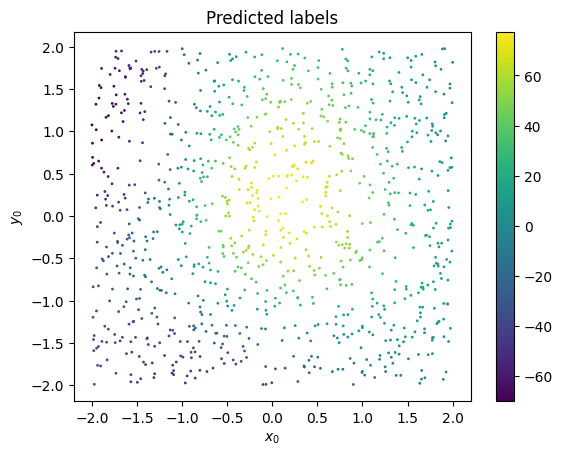

In [24]:
plt.scatter(dataset_test_uniform['x0'], dataset_test_uniform['y0'], c=raw_values, cmap='viridis', s=1)
plt.xlabel('$x_0$')
plt.ylabel('$y_0$')
plt.title('Predicted labels')
plt.colorbar()
plt.show()

In [25]:
predictions = model_2.predict(X_test_near)
accuracy = accuracy_score(y_test_near, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.634


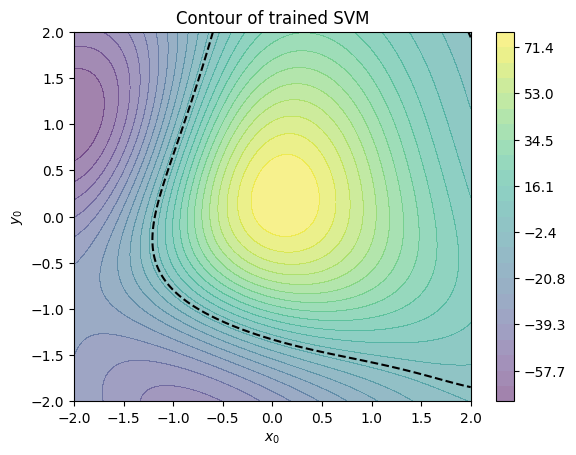

In [26]:
x_min, x_max = -2, 2
y_min, y_max = -2, 2
resolution = 2000
x_range = np.linspace(x_min, x_max, resolution)
y_range = np.linspace(y_min, y_max, resolution)
xx, yy = np.meshgrid(x_range, y_range)
grid = np.c_[xx.ravel(), yy.ravel()]
predictions = model_2.decision_function(grid).reshape(xx.shape)
plt.contourf(xx, yy, predictions, cmap='viridis', alpha=0.5, levels=np.linspace(predictions.min(), predictions.max(), 25))
plt.colorbar()
plt.contour(xx, yy, predictions, levels=[0], colors='k', linestyles='--')
plt.title("Contour of trained SVM")
plt.xlabel('$x_0$')
plt.ylabel('$y_0$')
plt.show()

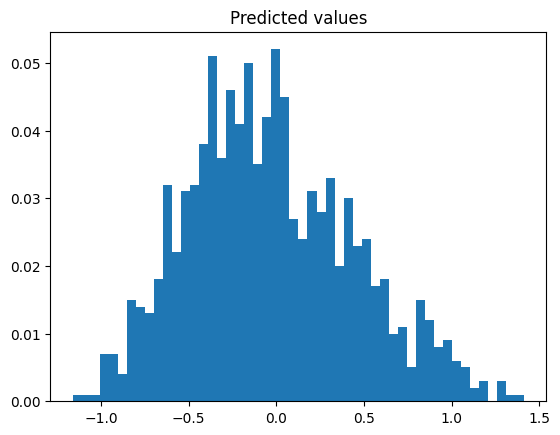

In [27]:
raw_values = model_2.decision_function(X_test_near)
weights = np.ones_like(raw_values)/float(len(raw_values))
plt.hist(raw_values, weights=weights, bins=50)
plt.title('Predicted values')
plt.show()

In [28]:
def compute_gradient_rbf_svm(model, x, X_train):
    # Handle gamma based on its type in the model
    if isinstance(model.gamma, str):
        if model.gamma == 'scale':
            # Calculate gamma as 1 / (n_features * X.var())
            gamma = 1 / (X_train.shape[1] * X_train.var())
        elif model.gamma == 'auto':
            # Calculate gamma as 1 / n_features
            gamma = 1 / X_train.shape[1]
        else:
            raise ValueError("Unsupported gamma setting")
    else:
        gamma = model.gamma

    X_sv = model.support_vectors_
    alphas = model.dual_coef_[0]  # Note: dual_coef_ = y_i * alpha_i
    b = model.intercept_[0]
    
    # Compute the gradient
    gradient = np.zeros_like(x)
    for i in range(len(X_sv)):
        K = np.exp(-gamma * np.linalg.norm(X_sv[i] - x)**2)
        gradient += -2 * gamma * (x - X_sv[i]) * K * alphas[i]
    
    return gradient

# Example usage, assuming X_train is your training dataset
x_point = np.array([1.0, 1.0])  # Point at which to compute the gradient
gradient = compute_gradient_rbf_svm(model_2, x_point, X_train)
print(f"Gradient at {x_point}: {gradient}")

Gradient at [1. 1.]: [-39.98940306 -19.42619563]


In [46]:
model_5 = SVC(kernel='rbf', C=150)
model_5.fit(X_train_augmented, y_train_augmented)

def dynamical_loss(model, points, b=system):
    loss = 0
    for point in points:
        gradient = compute_gradient_rbf_svm(model, point, X_train_augmented)
        vector = b(0, point)
        # Only normalize and compute dot product if both vectors are non-zero
        if np.any(gradient) and np.any(vector):
            normalized_gradient = gradient / np.linalg.norm(gradient)
            normalized_vector = vector / np.linalg.norm(vector)
            loss += np.dot(normalized_gradient, normalized_vector)**2
    return loss / len(points) if len(points) > 0 else 0


In [48]:
dynamical_loss(model_1, X_validation)

0.005321966144565365

In [56]:
def integrand(inputs, model, system, magnitude1=1.0):
    gradient_vectors = []
    system_vectors = []
    values = []
    for input_point in inputs:
        input_point = torch.tensor(input_point, dtype=torch.float32, requires_grad=True)
        value = model.decision_function(input_point.unsqueeze(0).detach().numpy())
        values.append(value[0])
        gradient_vector = compute_gradient_rbf_svm(model, input_point.detach().numpy(), X_train)
        gradient_vectors.append(gradient_vector)
        system_vector = system(0, input_point.detach().numpy())
        system_vectors.append(system_vector)
    normalized_gradient_vectors = [g / np.linalg.norm(g) if np.linalg.norm(g) > 0 else g for g in gradient_vectors]
    normalized_system_vectors = [s / np.linalg.norm(s) if np.linalg.norm(s) > 0 else s for s in system_vectors]
    dot_products = [(np.dot(g, s) ** 2) for g, s in zip(normalized_gradient_vectors, normalized_system_vectors)]
    gradient_norm = [np.linalg.norm(g) for g in gradient_vectors]
    dot_products = np.array(dot_products)
    gradient_norm = np.array(gradient_norm)
    values = np.array(values)
    #probability_values = net_3_1(torch.tensor(inputs, dtype=torch.float32)).detach().numpy()
    result = dot_products * gradient_norm
    def dirac(value, var = 0.0001):
        return np.exp(-(value)**2 / (2 * var**2)) / np.sqrt(2 * np.pi * var**2)
    return magnitude1 * result * dirac(values)

In [57]:
def integrate_function_over_region_batched(func, model, system, x_limits=(-2, 2), y_limits=(-2, 2), N=1000, batch_size=1000, magnitude=1):
    x_start, x_end = x_limits
    y_start, y_end = y_limits
    dx = (x_end - x_start) / N
    dy = (y_end - y_start) / N
    
    # Pre-compute linspace for efficiency
    x_space = np.linspace(x_start, x_end, N + 1)
    y_space = np.linspace(y_start, y_end, N + 1)
    
    total_points = (N + 1) ** 2
    num_batches = int(np.ceil(total_points / batch_size))
    
    integral = 0
    
    for batch in range(num_batches):
        start_idx = batch * batch_size
        end_idx = min(start_idx + batch_size, total_points)
        
        batch_indices = np.unravel_index(np.arange(start_idx, end_idx), (N + 1, N + 1))
        x_batch = x_space[batch_indices[1]]
        y_batch = y_space[batch_indices[0]]
        inputs = np.vstack([x_batch, y_batch]).T
        
        Z_batch = func(inputs, model, system, magnitude).reshape(-1)
        
        weights_batch = np.ones_like(Z_batch)
        
        if batch == 0:
            weights_batch[:N+1] *= 0.5
            weights_batch[::N+1] *= 0.5
        if batch == num_batches - 1:
            weights_batch[-(N+1):] *= 0.5
            weights_batch[N::N+1] *= 0.5
        
        integral += np.sum(Z_batch * weights_batch * dx * dy)
    
    return integral

# Integrate using the batch processing function
integral_value = integrate_function_over_region_batched(integrand, model_1, system)
print(f"Integral value: {integral_value}")

Integral value: 0.039822744556732514


In [70]:
def rbf_hinge_loss(model, X, y):
    hinge_loss = 0
    support_vectors = model.support_vectors_
    dual_coef = model.dual_coef_[0]
    gamma = model.gamma
    intercept = model.intercept_[0]
    if isinstance(gamma, str) and gamma == 'scale':
        n_features = X.shape[1]
        gamma = 1 / (n_features * X.var())
    for i in range(len(X)):
        x = X[i]
        y_i = y[i]
        decision_function = 0
        for j in range(len(support_vectors)):
            decision_function += dual_coef[j] * np.exp(-gamma * np.linalg.norm(support_vectors[j] - x)**2)
        decision_function += intercept
        hinge_loss += max(0, 1 - y_i * decision_function)
    return hinge_loss

def objective_function(params, X_train, y_train, X_validation, model):
    dual_coef = params[:-1]
    intercept = params[-1]
    
    model.dual_coef_ = dual_coef.reshape(1, -1)
    model.intercept_ = np.array([intercept])
    
    hinge_loss = rbf_hinge_loss(model, X_train, y_train)
    geometric_loss = dynamical_loss(model, X_validation)
    total_loss = hinge_loss + geometric_loss
    
    return total_loss
# Correctly initialize parameters
initial_params = np.append(model_1.dual_coef_.flatten(), model_1.intercept_)

optimization_progress = []

def track_progress(xk):
    global optimization_progress
    optimization_progress.append(xk)

result = minimize(objective_function, initial_params, args=(X_train, y_train, X_validation, model_1), callback=track_progress, options={'maxiter': 1000})

optimized_params = result.x
w_optimized = optimized_params[:-1]
b_optimized = optimized_params[-1]

print(f"Optimized SVM dual coefficients: {w_optimized}")
print(f"Optimized SVM intercept: {b_optimized}")


KeyboardInterrupt: 